In [86]:
import os
import pandas as pd
from functools import reduce
from statsmodels.tsa.stattools import adfuller, kpss
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

In [63]:
def adf_test(timeseries, regression = "c"):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC", regression = regression)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


def kpss_test(timeseries, regression = "c"):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression= regression, nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

## Procesos estacionarios

In [66]:
carpeta_base = r"C:\Users\josea\Documents\Insumos Series de Tiempo"
# Leemos la base
serie_ipc = pd.read_excel(os.path.join(carpeta_base, "IPC.xlsx"), skiprows=4)
# Convertimos los meses en español por números
meses = (("Enero", "1"), ("Febrero", "2"), ("Marzo", "3"), ("Abril", "4"), 
         ("Mayo", "5"), ("Junio", "6"), ("Julio","7"), ("Agosto", "8"), 
         ("Septiembre", "9"), ("Octubre", "10"), ("Noviembre", "11"), 
         ("Diciembre", "12"))
serie_ipc.columns = ["Mes", "Nivel", "Var_Mensual", "Var_IA", "Var_Acum"]
serie_ipc['Mes'] = serie_ipc['Mes'].apply(lambda x: reduce(
    lambda a, kv: a.replace(*kv), meses, x))
#Damos formato de fecha
serie_ipc['Mes'] = pd.to_datetime(serie_ipc['Mes'],format = "%m/%Y")
serie_ipc.index = serie_ipc['Mes'] 


In [68]:
serie_ipc.describe()

,Mes,Nivel,Var_Mensual,Var_IA,Var_Acum
count,582,582.000000,581.000000,570.000000,570.000000
mean,2000-03-16 18:30:55.670103040,41.911091,0.952557,12.911268,6.833680
min,1976-01-01 00:00:00,0.463418,-1.700893,-3.278103,-1.866064
25%,1988-02-08 06:00:00,4.436742,0.231592,4.837738,1.608657
50%,2000-03-16 12:00:00,27.990182,0.750582,10.324335,4.489953
75%,2012-04-23 12:00:00,83.655232,1.282460,15.353466,8.855782
max,2024-06-01 00:00:00,113.062770,10.730273,108.894610,81.752123
std,NaN,38.970587,1.218369,14.720704,9.484993


### Visualización

<Axes: xlabel='Mes', ylabel='Nivel'>

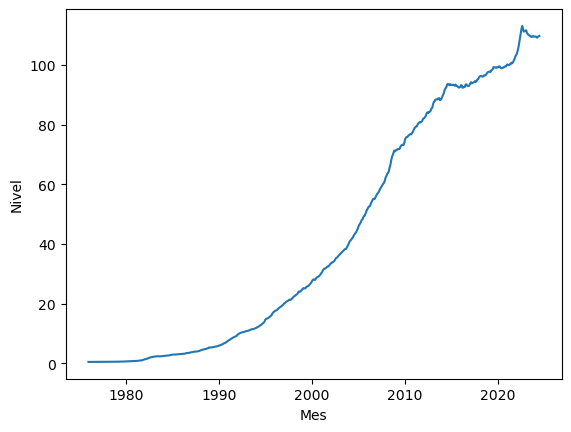

In [71]:
sns.lineplot(x="Mes", y = "Nivel",data = serie_ipc)

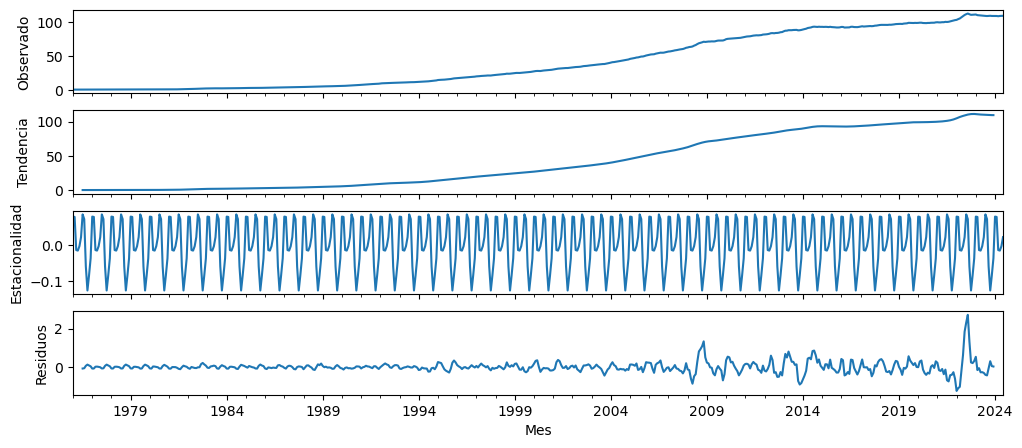

In [77]:
nivel_sd = seasonal_decompose(serie_ipc["Nivel"], model = "additive")

import matplotlib.pyplot as plt
import statsmodels.api as sm

def plotseasonal(descomp, axes):
    descomp.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observado')
    descomp.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Tendencia')
    descomp.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Estacionalidad')
    descomp.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residuos')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,5))
plotseasonal(nivel_sd, axes)

<Axes: xlabel='Mes', ylabel='Var_Mensual'>

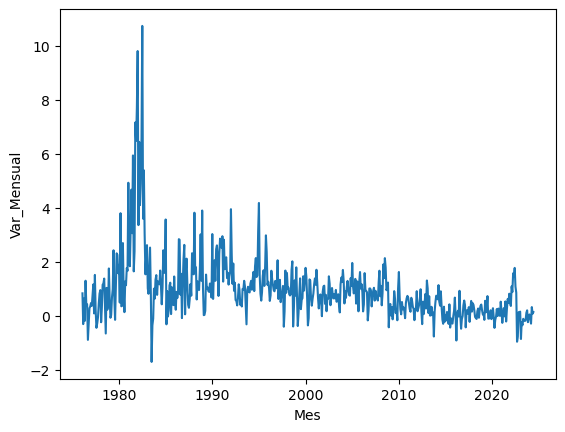

In [51]:
sns.lineplot(x="Mes", y = "Var_Mensual",data = serie_ipc)

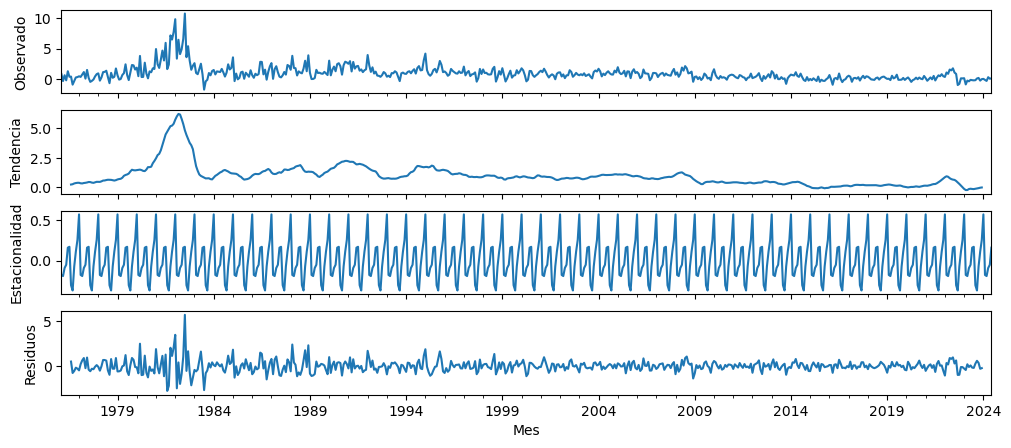

In [81]:
var_mens_sd = seasonal_decompose(serie_ipc["Var_Mensual"].dropna(), model = "additive")
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,5))
plotseasonal(var_mens_sd, axes)

### Pruebas estadísticas

In [ ]:
#Sobre la serie original
adf_test(serie_ipc['Nivel'], regression = "ct")

In [28]:
#Sobre la variación mensual
adf_test(serie_ipc['Var_Mensual'].dropna(), regression = "c")

Results of Dickey-Fuller Test:
Test Statistic                  -3.532072
p-value                          0.007201
#Lags Used                      19.000000
Number of Observations Used    561.000000
Critical Value (1%)             -3.442060
Critical Value (5%)             -2.866706
Critical Value (10%)            -2.569521
dtype: float64


In [32]:
#Sobre la variación interanual
adf_test(serie_ipc['Var_IA'].dropna(), regression = "ct")

Results of Dickey-Fuller Test:
Test Statistic                  -5.194254
p-value                          0.000090
#Lags Used                      19.000000
Number of Observations Used    550.000000
Critical Value (1%)             -3.975325
Critical Value (5%)             -3.418503
Critical Value (10%)            -3.131764
dtype: float64


### Transformaciones

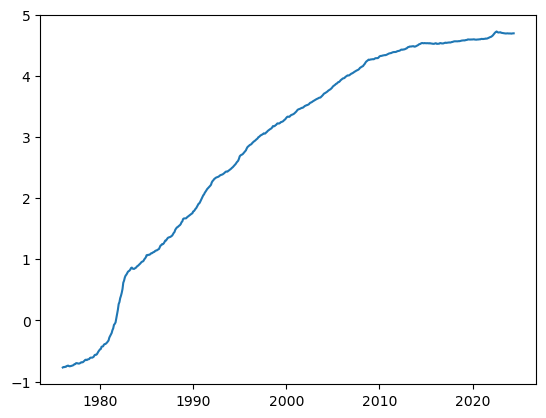

In [110]:
log_nivel = np.log(serie_ipc["Nivel"])
plt.plot(log_nivel)

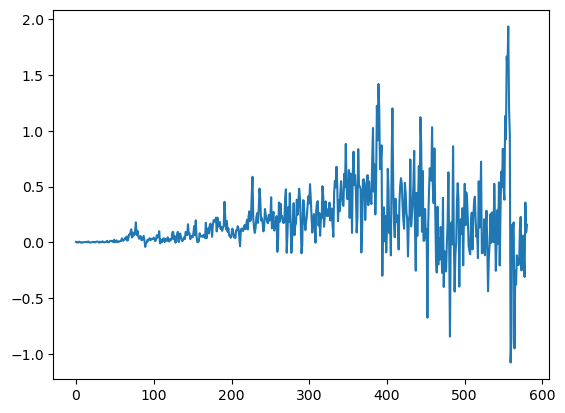

In [90]:
diff_nivel = np.diff(serie_ipc["Nivel"])
plt.plot(diff_nivel)

In [96]:
adf_test(diff_nivel, regression = "c")

Results of Dickey-Fuller Test:
Test Statistic                -5.940393e+00
p-value                        2.268222e-07
#Lags Used                     4.000000e+00
Number of Observations Used    5.760000e+02
Critical Value (1%)           -3.441754e+00
Critical Value (5%)           -2.866571e+00
Critical Value (10%)          -2.569449e+00
dtype: float64


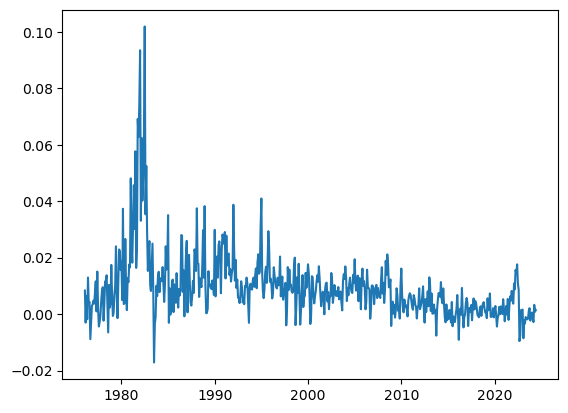

In [98]:
var_mensual_log = np.log(serie_ipc["Nivel"]).diff()
plt.plot(var_mensual_log)

In [106]:
serie_ipc['VarMensLog'] = np.log(serie_ipc["Nivel"]).diff()

In [108]:
serie_ipc['VarAnual'] = serie_ipc["Nivel"]/ serie_ipc["Nivel"].shift(12)-1
serie_ipc

,Mes,Nivel,Var_Mensual,Var_IA,Var_Acum,DiffNivel,VarAnual,VarMensLog
Mes,,,,,,,,
1976-01-01,1976-01-01,0.463418,NaN,NaN,NaN,NaN,NaN,NaN
1976-02-01,1976-02-01,0.467294,0.836456,NaN,NaN,0.003876,NaN,0.008330
1976-03-01,1976-03-01,0.465884,-0.301825,NaN,NaN,-0.001410,NaN,-0.003023
1976-04-01,1976-04-01,0.468892,0.645575,NaN,NaN,0.003008,NaN,0.006435
1976-05-01,1976-05-01,0.468032,-0.183266,NaN,NaN,-0.000859,NaN,-0.001834
...,...,...,...,...,...,...,...,...
2024-02-01,2024-02-01,109.411115,-0.107690,-1.131406,-0.052652,-0.117952,-0.011314,-0.001077
2024-03-01,2024-03-01,109.100527,-0.283872,-1.186315,-0.336374,-0.310587,-0.011863,-0.002843
2024-04-01,2024-04-01,109.457782,0.327454,-0.520813,-0.010021,0.357255,-0.005208,0.003269
